In [104]:
import copy
import json
import os
import pathlib
import sys
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

# shap displays NumbaDeprecationWarning when importing -- supress them
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import shap
import torch
from torch import Tensor, sigmoid

import logging
# do not display logging messages whatsoever
logging.disable(logging.CRITICAL)

# correct path to repository root
REPOSITORY_ROOT = os.path.join(os.getcwd(), "..", "..", "..")
sys.path.append(REPOSITORY_ROOT)

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderOptionalEmbedding
from nebula.preprocessing import JSONTokenizerBPE

from nebula.misc.plots import set_size
from nebula.misc import fix_random_seed
fix_random_seed(0)


def compute_score(llm, x, verbose=True):
    logit = llm(x)
    prob = sigmoid(logit)
    if verbose:
        print(f"\n[!!!] Probability of being malicious: {prob.item():.3f} | Logit: {logit.item():.3f}")
    return prob.item()


def load_tokenizer():
    with open(os.path.join(
        REPOSITORY_ROOT,
        "nebula",
        "objects",
        "speakeasy_BPE_50000_sentencepiece_vocab.json"
    )) as f:
        vocab = json.load(f)
    tokenizer = JSONTokenizerBPE(
        vocab_size=len(vocab),
        seq_len=512,
        model_path=os.path.join(
            REPOSITORY_ROOT,
            "nebula",
            "objects",
            "speakeasy_BPE_50000_sentencepiece.model"
        )
    )
    return tokenizer


def tokenize_sample(report_path, encode=True):
    extractor = PEDynamicFeatureExtractor()
    filtered_report = extractor.filter_and_normalize_report(report_path)
    tokenizer = load_tokenizer()
    if encode:
        encoded_report = tokenizer.encode(filtered_report, pad=True)#, tokenize=False)
        x = Tensor(encoded_report).long()
        return x
    else:
        tokenized_report = tokenizer.tokenize(filtered_report)
        return tokenized_report


def embed(llm_model, report, device="cpu"):
    src = tokenize_sample(report)
    s = llm_model.split(src)
    s = s.to(device)
    e = llm_model.embed(s)
    return e


def plot_shap_values(shap_values: np.ndarray, name: str, figsize=(20, 5), start_idx=1):
    shap_values = shap_values.mean(axis=2)
    pos_idx = shap_values[0] >= 0
    neg_index = shap_values[0] < 0
    pos_shap = copy.deepcopy(shap_values)[0]
    pos_shap[neg_index] = 0
    neg_shap = copy.deepcopy(shap_values)[0]
    neg_shap[pos_idx] = 0
    x = range(512)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.bar(x[start_idx:], pos_shap[start_idx:], color="tab:red")
    ax.bar(x[start_idx:], neg_shap[start_idx:], color="tab:blue")
    ax.set_title(name)
    return ax


def load_model(skip_embedding=False):
    pretrained_model = os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_BPE_50000_torch.model")
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_BPE_50000_sentencepiece_vocab.json")) as f:
        vocab = json.load(f)
    model_config = {
        "vocab_size": len(vocab),
        "maxlen": 512,
        "chunk_size": 64,  # input splitting to chunks
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1,  # binary classification
        "hiddenNeurons": [64],  # classifier ffnn dims
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True,
        "skip_embedding": skip_embedding
    }
    state_dict = torch.load(pretrained_model, map_location='cpu')
    llm = TransformerEncoderOptionalEmbedding(**model_config)
    llm.load_state_dict(state_dict)
    llm.eval()
    return llm


def analyse_sample(
        exampleFile,
        llm_model,
        embed_baseline,
        name,
        plot=True,
        verbose=True,
        figsize=(20, 5),
        start=1
):
    x_embed = embed(llm_model, exampleFile)
    prob = compute_score(llm_model, x_embed, verbose=verbose)
    explainer = shap.GradientExplainer(model_no_embed, data=embed_baseline)
    explanations = explainer.shap_values(x_embed, nsamples=50)
    if plot:
        ax = plot_shap_values(explanations, f"{name} : {prob:.3f}", figsize=figsize, start_idx=start)
        return explanations, ax
    else:
        return explanations


def analyse_folder(
        folder: pathlib.Path,
        llm_model,
        embed_baseline,
        name,
        plot=True,
        verbose=True
):
    filepaths = []
    explanations_arr = []
    for i, report in enumerate(folder.glob("*.json")):
        print(report.name)
        filepaths.append(report.name)
        with open(report) as f:
            report = json.load(f)
        explanations = analyse_sample(
            report,
            llm_model,
            embed_baseline,
            name,
            plot=plot,
            verbose=verbose
        )
        explanations_arr.append(explanations)
    return filepaths, explanations_arr


model = load_model()
model_no_embed = load_model(skip_embedding=True)

malware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "malware"))
goodware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "goodware"))

baseline_report = os.path.join(REPOSITORY_ROOT, r"emulation", "report_baseline.json")
x_baseline = tokenize_sample(baseline_report)
x_embed_baseline = embed(model, baseline_report)


[!!!] Probability of being malicious: 0.710 | Logit: 0.895


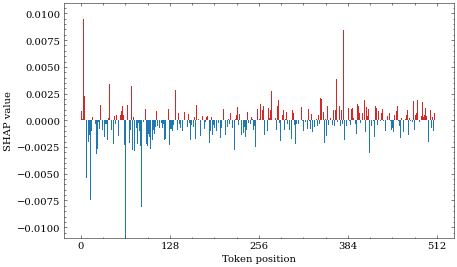

In [115]:
example_backdoor_path = os.path.join("..", "malware", "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(example_backdoor_path) as f:
    example_backdoor = json.load(f)
explanations_backdoor, ax = analyse_sample(
    example_backdoor,
    model_no_embed,
    x_embed_baseline,
    "Malware",
    plot=True,
    verbose=True,
    figsize=set_size(),
    start=1
)
ax.set_ylim(-0.011, 0.011)
_ = ax.set_title("")
_ = ax.set_xlabel("Token position")
_ = ax.set_ylabel("SHAP value")
_ = ax.set_xticks([0, 128, 256, 384, 512])
_ = ax.set_xticklabels([0, 128, 256, 384, 512])
# dump figure
fig_path = os.path.join(REPOSITORY_ROOT, "img", "shap_backdoor.pdf")
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)


[!!!] MALWARE FOLDER
0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json

[!!!] Probability of being malicious: 0.710 | Logit: 0.895


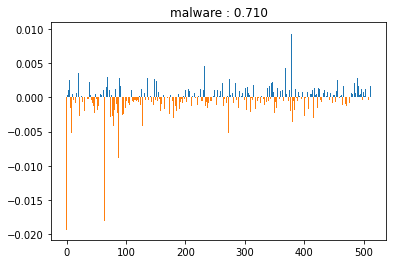

0a0358122fbf7713bc100f9d0757747e991079c1f7a393aacb5c1fcbe1ff7065.dat.json

[!!!] Probability of being malicious: 0.670 | Logit: 0.708


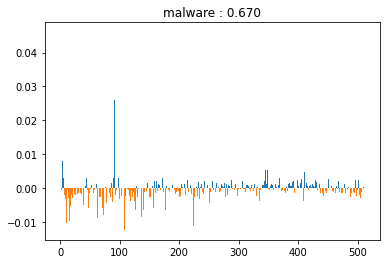

0a677fb789978cdd22f6c0c66a5cf01a9e2fd6d9fcb6484b2385d9354f0632f2.dat.json

[!!!] Probability of being malicious: 0.999 | Logit: 6.890


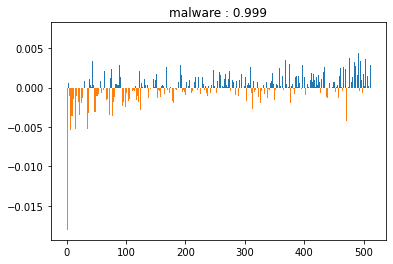

0a711ca925166cadd3c73802b3ba569bf6a6f951fded4c60ccc6ecc2c756473d.dat.json

[!!!] Probability of being malicious: 0.650 | Logit: 0.618


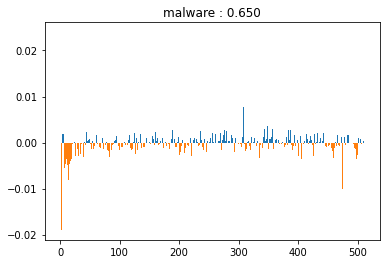

0afa6b5d80f2f3a56c9144d2033b3ea168abb86bbe5e26bc71eccbcf8a0be93a.dat.json

[!!!] Probability of being malicious: 1.000 | Logit: 12.255


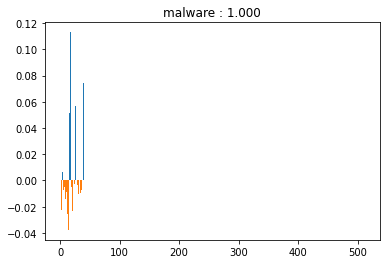

0b1e9a9d060e20685b2718d0a6667e76459ca141ea062b883873ceaa16afb5d9.dat.json

[!!!] Probability of being malicious: 0.252 | Logit: -1.088


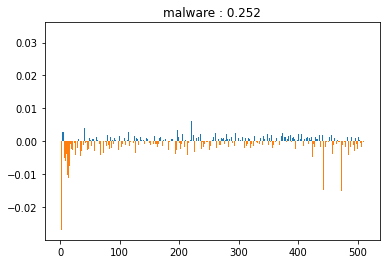

0b30e9492b3d43bddf9be4d2f29441f2318b2958e37cfda8efc07f5257c949c9.dat.json

[!!!] Probability of being malicious: 0.942 | Logit: 2.790


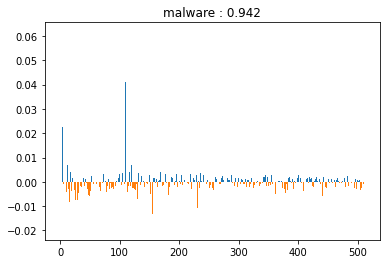

0b6a25fdef6575f6aea7941c63a8a0a740a6754acae7d32f5a590dcae01d27fc.dat.json

[!!!] Probability of being malicious: 0.996 | Logit: 5.522


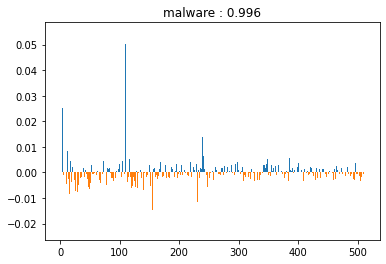

0b6c3923a7d34f3062dab70853887a2a3c8bdb009e9a110d4a554bef892b26fd.dat.json

[!!!] Probability of being malicious: 0.002 | Logit: -6.052


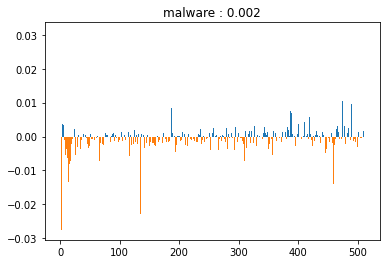


[!!!] GOODWARE FOLDER
0a0ba23720d5afda91ccb93bda9e560473cce055bf2f516d36cc23a9c3a42e60.dat.json

[!!!] Probability of being malicious: 0.131 | Logit: -1.895


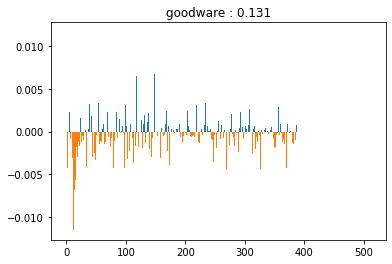

0a1e8fd4416c21fa74171048a53eaeeb958d77b1c44986633110c01c0c91b38e.dat.json

[!!!] Probability of being malicious: 0.000 | Logit: -7.621


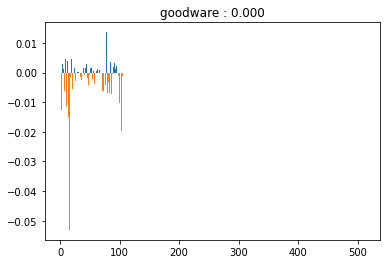

0a2b0354ac9b5ec2967412f0577f2f803b93693283101b417eba342ce1205eaa.dat.json

[!!!] Probability of being malicious: 0.012 | Logit: -4.431


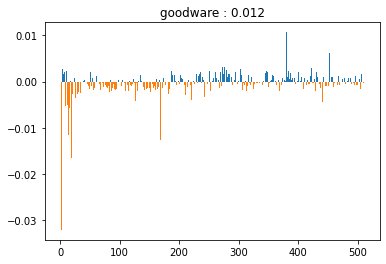

0a3bbeb27e09ef22c94f7440d07bedde479e0e9f122fe51b6f86b4634120221b.dat.json

[!!!] Probability of being malicious: 0.078 | Logit: -2.473


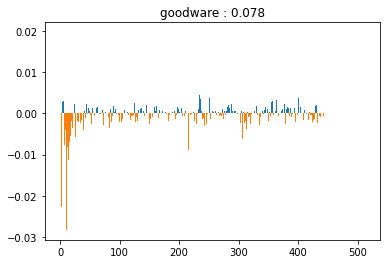

0a4a72fe3cc032f6270ffbd460bb1e68ef005795334e3e478e95965469591681.dat.json

[!!!] Probability of being malicious: 0.006 | Logit: -5.040


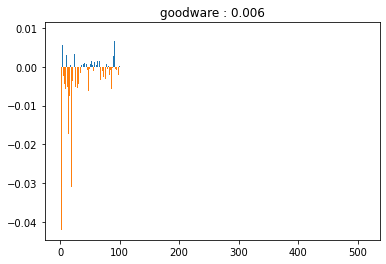

0a4e5a5bb11126116ea610019c1ec5ee5d3a3312dfa1975f94acc13eb1545d58.dat.json

[!!!] Probability of being malicious: 0.323 | Logit: -0.741


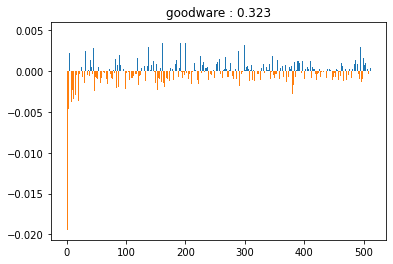

0a57cc32471142bd98fd1aa1004826a03edfef99698d990cd4c5a746c78a65ff.dat.json

[!!!] Probability of being malicious: 0.033 | Logit: -3.368


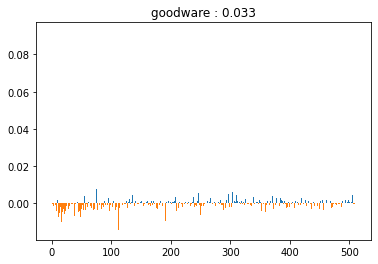

0a5efb412ca54bce23961cef891c28e0e76a5bef2aa776f35374f4d7bfec9aa5.dat.json

[!!!] Probability of being malicious: 0.016 | Logit: -4.102


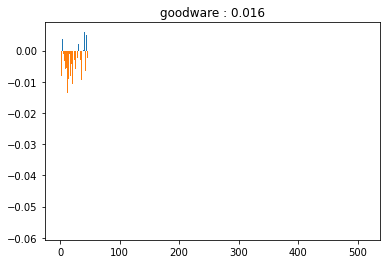

In [12]:
print(f"\n[!!!] MALWARE FOLDER")
filepaths, explanations = analyse_folder(malware_folder, model_no_embed, x_embed_baseline, "malware")

print(f"\n[!!!] GOODWARE FOLDER")
_ = analyse_folder(goodware_folder, model_no_embed, x_embed_baseline, "goodware")

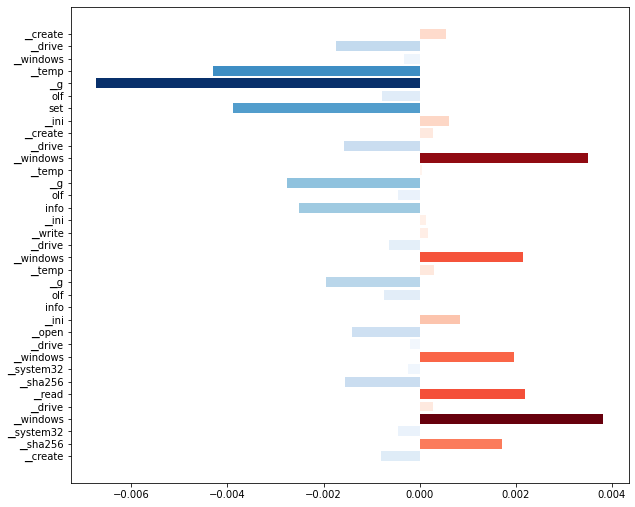

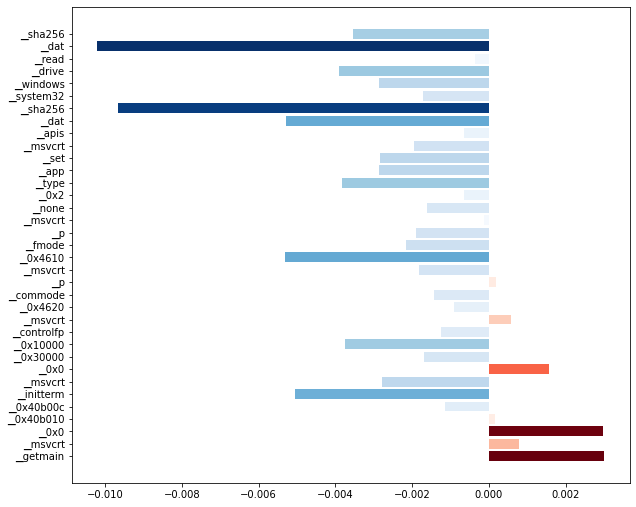

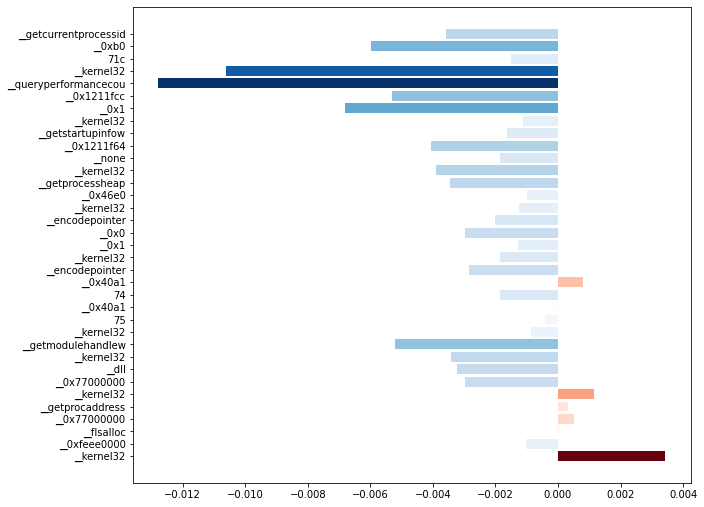

In [67]:
def plot_single_importance(filepath, explanation, start, end, token_max_len=15, figsize=None):
    sample_values = explanation.mean(axis=2)[:,start:end][0].tolist()[::-1]
    sample_tokens = tokenize_sample(os.path.join(malware_folder, filepath), encode=False)
    sample_tokens = sample_tokens[0][start:end][::-1]
    # limit length of every element in sample tokens to max 15 chars
    sample_tokens = [token[:token_max_len] for token in sample_tokens]

    if figsize is None:
        ysize = len(sample_tokens) * 0.25
        figsize = (10, ysize)
    fig, ax = plt.subplots(figsize=figsize)
    x = range(len(sample_tokens))    
    # assign color to each bar based on value:
    # -- the higher value, the more red
    # -- if value is below 0, then use blue instead of red
    colors = []
    mmax = max(sample_values)
    mmin = min(sample_values)
    for value in sample_values:
        if value > 0:
            c = plt.cm.Reds(value / mmax)
        else:
            c = plt.cm.Blues(value / mmin)
        colors.append(c)
    ax.barh(x, sample_values, color=colors)
    ax.set_yticks(x, sample_tokens)

    # compute_score
    x = tokenize_sample(os.path.join(malware_folder, filepath))
    prob = compute_score(model, x, verbose=False)
    #ax.set_title(f"{filepath} : {prob:.3f}")
    return ax

def plot_importance(filepaths, explanations, start=0, end=100, token_max_len=20):
    """
    It should plot the string values along y-axis and plot bars
    with length and color equal to the float values in red/orange heatmap colorscheme.
    """
    assert len(filepaths) == len(explanations), "Number of filepaths and explanations must be equal"
    axs = []
    for idx in range(len(filepaths)):
        ax = plot_single_importance(filepaths[idx], explanations[idx], start, end, token_max_len)
        axs.append(ax)
    return axs

_ = plot_importance(
    filepaths=filepaths[0:3],
    explanations=explanations[0:3],
    start=10,
    end=45
)

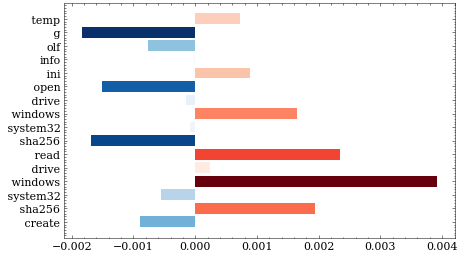

In [85]:
from nebula.misc.plots import set_size
import scienceplots
plt.style.use(['science', 'no-latex'])
ax = plot_single_importance(
    example_backdoor_path,
    explanations_backdoor,
    start=29,
    end=45,
    figsize=set_size()
)
# increase xticks font size
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(11)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(11)

# replace "▁" with " " in yticklabels
yticklabels = [label.get_text().replace("▁", " ") for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)
# save 
imgfolder = os.path.join(REPOSITORY_ROOT, "img")
plt.savefig(os.path.join(imgfolder, "shap_backdoor_fragment.pdf"), bbox_inches='tight')